<a href="https://colab.research.google.com/github/dhruvprabhu/Tweet-Support-Classification/blob/main/BTP2_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries


In [ ]:
!pip install emoji
!pip install wordninja

In [ ]:
!pip install transformers

In [ ]:
import re
import random as rd
import math
import string
import numpy as np
import pandas as pd
import emoji
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, TFBertModel
import wordninja
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# specify GPU
device = torch.device("cuda")



# Load Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Deep Learning/annotations - Final_Dataset.csv')
df = df[df['Reply_Class'] != 'Lang']
df['Reply_Class'] = df['Reply_Class'].astype(int)

In [ ]:
df

,Tweet ID,Text,Tweet Class,Reply,Reply_Class
0,1.422169e+18,"The Ministry of Agriculture, Irrigation and Li...",I,The cost of building this silo is estimated at...,1
1,1.422082e+18,10 years ago. I dread to think what these boys...,E,You killed there brothers and sisters in bombi...,-1
2,1.422082e+18,10 years ago. I dread to think what these boys...,E,But dozens of your interpreters are left behin...,0
3,1.422082e+18,10 years ago. I dread to think what these boys...,E,What a heart wrenching thought... I love that ...,1
4,1.421904e+18,Bodies on the streets': Fighting brings death ...,E,https://en.m.wikipedia.org/wiki/Sahibzada_Abdu...,0
...,...,...,...,...,...
3030,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,🙏🙏,1
3031,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,@hassankhalid635,0
3032,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,RIP,1
3033,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,Unlikely that things are going to get better i...,0


In [ ]:
#encoding -1 to 0 , 0 to 1 and 1 to 2
df['Reply_Class'] = df['Reply_Class'] + 1
df

,Tweet ID,Text,Tweet Class,Reply,Reply_Class
0,1.422169e+18,"The Ministry of Agriculture, Irrigation and Li...",I,The cost of building this silo is estimated at...,2
1,1.422082e+18,10 years ago. I dread to think what these boys...,E,You killed there brothers and sisters in bombi...,0
2,1.422082e+18,10 years ago. I dread to think what these boys...,E,But dozens of your interpreters are left behin...,1
3,1.422082e+18,10 years ago. I dread to think what these boys...,E,What a heart wrenching thought... I love that ...,2
4,1.421904e+18,Bodies on the streets': Fighting brings death ...,E,https://en.m.wikipedia.org/wiki/Sahibzada_Abdu...,1
...,...,...,...,...,...
3030,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,🙏🙏,2
3031,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,@hassankhalid635,1
3032,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,RIP,2
3033,1.415929e+18,Terrible Terrible news. Our dearest Danish Sid...,I,Unlikely that things are going to get better i...,1


# Preprocessing

In [ ]:
from transformers import BertTokenizer




In [ ]:

def pre_process_tweet(tweet):
    # Remove \n from the end of the sentence
    tweet = tweet.strip('\n')

    # Convert emojis to their descriptions
    tweet = emoji.demojize(tweet)
    # Add spaces between emoji descriptions
    tweet = re.sub(r'(:\w+:)', lambda x: x.group(0).replace(':', ' '), tweet)

    # Remove any URL
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www\S+", "", tweet)

    # Convert underscore-separated words to space-separated words
    tweet = re.sub(r'_', ' ', tweet)

    # Convert dash-separated words to space-separated words
    tweet = re.sub(r'-', ' ', tweet)

    # Replace &amp with 'and'
    tweet = tweet.replace('&amp','and')
    tweet = tweet.replace('&AMP','and')

    # Replace U.S. with 'usa'
    tweet = tweet.replace('U.S.', 'usa')
    tweet = tweet.replace('US','usa')
    # Remove colons from the end of the sentences (if any)
    tweet = tweet.strip()
    if tweet.endswith(':'):
        tweet = tweet[:-1]

    # Convert every word to lowercase
    tweet = tweet.lower()


    tweet = tweet.replace('#', '')
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Trim extra spaces
    tweet = " ".join(tweet.split())

    return tweet


In [ ]:
df['Text'] = df['Text'].apply(pre_process_tweet)
df['Reply'] = df['Reply'].apply(pre_process_tweet)

In [ ]:
# Used to seperate words
df['Text'] = df['Text'].apply(lambda x: ' '.join(wordninja.split(x)))
df['Reply'] = df['Reply'].apply(lambda x: ' '.join(wordninja.split(x)))

In [ ]:
df['Text'] = df['Text'] + "." + df['Reply']

In [ ]:
df['Text'][0]

'the ministry of agriculture irrigation and livestock says a 20000 metric transportable metal silo will be built to store wheat in her at province through the ministry of agriculture s emergency agriculture and food supply project eats afghanistan.the cost of building this silo is estimated at five million dollars 22'

# Train Test Val Split

In [ ]:

train_text, temp_text, train_labels, temp_labels = train_test_split(df['Text'], df['Reply_Class'],
                                                                   random_state=2018,
                                                                   test_size=0.2,
                                                                   stratify=df['Reply_Class'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                               random_state=2018,
                                                               test_size=0.5,
                                                               stratify=temp_labels)


<Axes: >

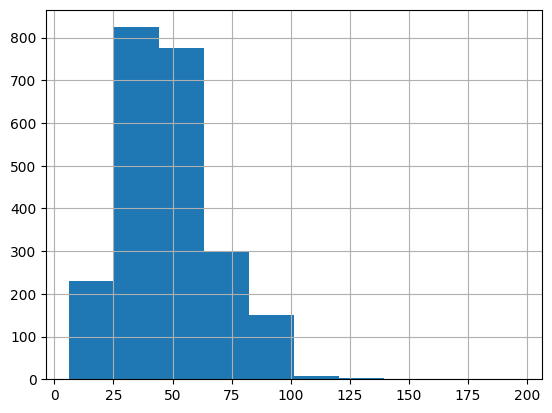

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

# Import Bert Model and Bert Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["hello hello . how the hell. are uo , i amena"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
sent_id['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

# Tokenization

In [ ]:
max_seq_len = 150

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
   test_text.tolist(),
   max_length = max_seq_len,
   pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


# Define Model Arch

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)


    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert) #, fine_tune_layers = [9,10,11])

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[1.16412602 0.86681801 1.01282051]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 50

# Fine Tune Bert

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # calculate accuracy
    preds_class = preds.argmax(dim=1)
    correct_preds = (preds_class == labels).sum().item()
    total_accuracy += correct_preds

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss and accuracy of the epoch
  avg_loss = total_loss / len(train_dataloader)
  avg_accuracy = total_accuracy / len(train_dataloader.dataset)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds, avg_accuracy

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      # calculate accuracy
      preds_class = preds.argmax(dim=1)
      correct_preds = (preds_class == labels).sum().item()
      total_accuracy += correct_preds

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  avg_accuracy = total_accuracy / len(val_dataloader.dataset)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds, avg_accuracy

# Start Model Training

In [ ]:
import csv
model_file_path = '/content/drive/MyDrive/Deep Learning/second_trained_model_weights.pt'
history_file_path = '/content/drive/MyDrive/Deep Learning/second_training_history.csv'


In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
train_accuracies = []
valid_accuracies = []

# history dictionary to store information for each epoch
history = {'train_loss': [], 'train_accuracy': [], 'valid_loss': [], 'valid_accuracy': []}

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ , train_accuracy= train()

    #evaluate model
    valid_loss, _ , valid_accuracy = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        with open(model_file_path, 'wb') as file:
          torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning/second_trained_model_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # store information in history dictionary
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['valid_loss'].append(valid_loss)
    history['valid_accuracy'].append(valid_accuracy)


    print(f'\nTraining Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {valid_loss:.3f}, Validation Accuracy: {valid_accuracy:.4f}')


# save the entire history as CSV
with open(history_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # write the header
    csv_writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    # write data for each epoch
    for epoch, (train_loss, train_accuracy, valid_loss, valid_accuracy) in enumerate(
            zip(train_losses, train_accuracies, valid_losses, valid_accuracies), 1):
        csv_writer.writerow([epoch, train_loss, train_accuracy, valid_loss, valid_accuracy])

print(f'History saved as CSV file: {history_file_path}')



 Epoch 1 / 50
  Batch    50  of     72.

Evaluating...

Training Loss: 1.126, Training Accuracy: 0.3662
Validation Loss: 1.112, Validation Accuracy: 0.2902

 Epoch 2 / 50
  Batch    50  of     72.

Evaluating...

Training Loss: 1.096, Training Accuracy: 0.3797
Validation Loss: 1.060, Validation Accuracy: 0.4895

 Epoch 3 / 50
  Batch    50  of     72.

Evaluating...

Training Loss: 1.075, Training Accuracy: 0.4120
Validation Loss: 1.037, Validation Accuracy: 0.4755

 Epoch 4 / 50
  Batch    50  of     72.

Evaluating...

Training Loss: 1.066, Training Accuracy: 0.4313
Validation Loss: 1.050, Validation Accuracy: 0.4056

 Epoch 5 / 50
  Batch    50  of     72.

Evaluating...

Training Loss: 1.054, Training Accuracy: 0.4356
Validation Loss: 1.016, Validation Accuracy: 0.4790

 Epoch 6 / 50
  Batch    50  of     72.

Evaluating...

Training Loss: 1.053, Training Accuracy: 0.4435
Validation Loss: 0.991, Validation Accuracy: 0.5070

 Epoch 7 / 50
  Batch    50  of     72.

Evaluating...

T

In [ ]:
import pandas as pd

def find_max_valid_accuracy(file_path):
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Find the maximum valid_accuracy
        max_valid_accuracy = df['valid_accuracy'].max()

        # Print the maximum valid_accuracy
        print("Maximum validation accuracy:", max_valid_accuracy)
    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print("An error occurred:", e)

# Example usage:
file_path = input()
find_max_valid_accuracy(file_path)


/content/drive/MyDrive/Deep Learning/second_training_history.csv
Maximum validation accuracy: 0.6013986013986014
